In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import *
import numpy as np
%matplotlib inline

## Подготовка и визуализация данных

In [7]:
train_loader, valid_loader, test_loader = mnist(valid=10000, batch_size=50)

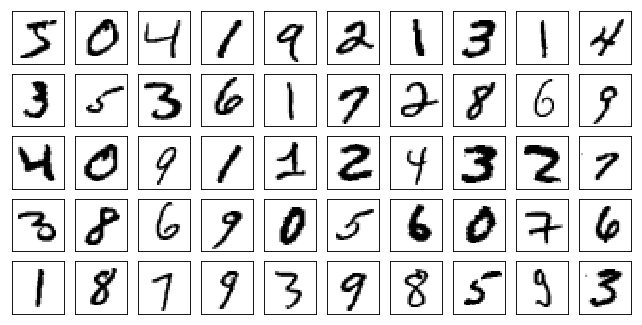

In [8]:
images = mnist_plotdata()
plot_mnist(images, (5, 10))

## Обучение классификатора

In [9]:
class ConvLayer(nn.Module):
    def __init__(self, size, padding=1, pool_layer=nn.MaxPool2d(2, stride=2),
                 bn=False, dropout=False, activation_fn=nn.ReLU()):
        super(ConvLayer, self).__init__()
        layers = []
        layers.append(nn.Conv2d(size[0], size[1], size[2], padding=padding))
        if pool_layer is not None:
            layers.append(pool_layer)
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [10]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh):
        super(FullyConnected, self).__init__()
        layers = []
        
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout())
            layers.append(activation_fn())
        else: # нам не нужен дропаут и фнкция активации в последнем слое
            layers.append(nn.Linear(sizes[-2], sizes[-1]))            
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [11]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        
        
        self._conv1 = ConvLayer([1, 16, 3], bn=batchnorm)
        self._conv2 = ConvLayer([16, 32, 3], bn=batchnorm, activation_fn=nn.Sigmoid())
        
        self.fc = FullyConnected([32*7*7, 10], dropout=dropout)
        
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
    
    def conv(self, x):
        x = self._conv1(x)
        x = self._conv2(x)
        return x
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 32*7*7)
        x = self.fc(x)
        
        return x
    
    def loss(self, output, target, **kwargs):           
        self._loss = F.cross_entropy(output, target, **kwargs)
        self._correct = output.data.max(1, keepdim=True)[1]
        self._correct = self._correct.eq(target.data.view_as(self._correct)).to(torch.float).cpu().mean()
        return self._loss

In [12]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._correct))
        print(line + losses)

In [8]:
models = {'bn': Net(True), 'drop': Net(False, True), 'plain': Net()}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [9]:
def test(models, loader, log=None):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], target, size_average=False).item() # sum up batch loss
                pred = output[k].data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum().item()
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: c / test_size for k, c in correct.items()}
    lines = '\n'.join([line(k, test_loss[k], correct[k], 100*correct_pct[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [10]:
for epoch in range(1, 41):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses bn: 2.327237 drop: 2.327067 plain: 2.398716
Train Epoch: 1 [10000/50000 (20%)]	Losses bn: 1.940708 drop: 2.064648 plain: 2.166881
Train Epoch: 1 [20000/50000 (40%)]	Losses bn: 1.701396 drop: 1.560394 plain: 1.792192
Train Epoch: 1 [30000/50000 (60%)]	Losses bn: 1.356526 drop: 1.018548 plain: 1.202888
Train Epoch: 1 [40000/50000 (80%)]	Losses bn: 0.990829 drop: 0.651022 plain: 0.738635
Train Epoch: 1 [50000/50000 (100%)]	Losses bn: 0.963648 drop: 0.721057 plain: 0.716659
Test set:
bn: Loss: 0.9073	Accuracy: 8850.0/10000 (88%)
drop: Loss: 0.6407	Accuracy: 8445.0/10000 (84%)
plain: Loss: 0.6657	Accuracy: 8510.0/10000 (85%)

Train Epoch: 2 [0/50000 (0%)]	Losses bn: 0.997129 drop: 0.727063 plain: 0.745833
Train Epoch: 2 [10000/50000 (20%)]	Losses bn: 0.682070 drop: 0.406315 plain: 0.428687
Train Epoch: 2 [20000/50000 (40%)]	Losses bn: 0.486867 drop: 0.359889 plain: 0.347797
Train Epoch: 2 [30000/50000 (60%)]	Losses bn: 0.545352 drop: 0.371274 plain: 0.34

Train Epoch: 13 [30000/50000 (60%)]	Losses bn: 0.097599 drop: 0.141717 plain: 0.099757
Train Epoch: 13 [40000/50000 (80%)]	Losses bn: 0.087630 drop: 0.099346 plain: 0.125132
Train Epoch: 13 [50000/50000 (100%)]	Losses bn: 0.072654 drop: 0.091802 plain: 0.093036
Test set:
bn: Loss: 0.0702	Accuracy: 9790.0/10000 (98%)
drop: Loss: 0.0874	Accuracy: 9761.0/10000 (98%)
plain: Loss: 0.0818	Accuracy: 9784.0/10000 (98%)

Train Epoch: 14 [0/50000 (0%)]	Losses bn: 0.029795 drop: 0.061071 plain: 0.057620
Train Epoch: 14 [10000/50000 (20%)]	Losses bn: 0.078697 drop: 0.104760 plain: 0.097463
Train Epoch: 14 [20000/50000 (40%)]	Losses bn: 0.039354 drop: 0.049134 plain: 0.053806
Train Epoch: 14 [30000/50000 (60%)]	Losses bn: 0.115576 drop: 0.137587 plain: 0.077492
Train Epoch: 14 [40000/50000 (80%)]	Losses bn: 0.049868 drop: 0.040388 plain: 0.031665
Train Epoch: 14 [50000/50000 (100%)]	Losses bn: 0.050742 drop: 0.038363 plain: 0.041651
Test set:
bn: Loss: 0.0659	Accuracy: 9822.0/10000 (98%)
drop: Loss

Train Epoch: 25 [50000/50000 (100%)]	Losses bn: 0.062874 drop: 0.063268 plain: 0.067614
Test set:
bn: Loss: 0.0466	Accuracy: 9864.0/10000 (99%)
drop: Loss: 0.0584	Accuracy: 9846.0/10000 (98%)
plain: Loss: 0.0562	Accuracy: 9838.0/10000 (98%)

Train Epoch: 26 [0/50000 (0%)]	Losses bn: 0.026951 drop: 0.027114 plain: 0.026477
Train Epoch: 26 [10000/50000 (20%)]	Losses bn: 0.022352 drop: 0.034438 plain: 0.032168
Train Epoch: 26 [20000/50000 (40%)]	Losses bn: 0.020409 drop: 0.032141 plain: 0.032243
Train Epoch: 26 [30000/50000 (60%)]	Losses bn: 0.005217 drop: 0.033979 plain: 0.023460
Train Epoch: 26 [40000/50000 (80%)]	Losses bn: 0.025118 drop: 0.013730 plain: 0.014087
Train Epoch: 26 [50000/50000 (100%)]	Losses bn: 0.044910 drop: 0.037579 plain: 0.045741
Test set:
bn: Loss: 0.0484	Accuracy: 9867.0/10000 (99%)
drop: Loss: 0.0591	Accuracy: 9844.0/10000 (98%)
plain: Loss: 0.0568	Accuracy: 9841.0/10000 (98%)

Train Epoch: 27 [0/50000 (0%)]	Losses bn: 0.018049 drop: 0.011464 plain: 0.011011
Trai

Train Epoch: 38 [10000/50000 (20%)]	Losses bn: 0.005484 drop: 0.023479 plain: 0.014725
Train Epoch: 38 [20000/50000 (40%)]	Losses bn: 0.021665 drop: 0.028262 plain: 0.029909
Train Epoch: 38 [30000/50000 (60%)]	Losses bn: 0.003145 drop: 0.008260 plain: 0.005832
Train Epoch: 38 [40000/50000 (80%)]	Losses bn: 0.017277 drop: 0.018855 plain: 0.023037
Train Epoch: 38 [50000/50000 (100%)]	Losses bn: 0.071951 drop: 0.054389 plain: 0.047094
Test set:
bn: Loss: 0.0425	Accuracy: 9877.0/10000 (99%)
drop: Loss: 0.0506	Accuracy: 9862.0/10000 (99%)
plain: Loss: 0.0484	Accuracy: 9858.0/10000 (99%)

Train Epoch: 39 [0/50000 (0%)]	Losses bn: 0.003092 drop: 0.005656 plain: 0.006828
Train Epoch: 39 [10000/50000 (20%)]	Losses bn: 0.009749 drop: 0.012060 plain: 0.008190
Train Epoch: 39 [20000/50000 (40%)]	Losses bn: 0.024282 drop: 0.028808 plain: 0.028665
Train Epoch: 39 [30000/50000 (60%)]	Losses bn: 0.031108 drop: 0.047713 plain: 0.055226
Train Epoch: 39 [40000/50000 (80%)]	Losses bn: 0.002226 drop: 0.009

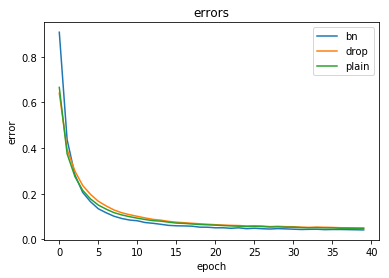

In [11]:
plot_graphs(test_log, 'loss')

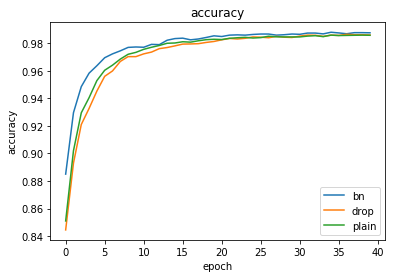

In [12]:
plot_graphs(test_log, 'accuracy')

In [13]:
torch.save(models['bn'], './model_classifier_convs')

/Users/aleksey/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/aleksey/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type ConvLayer. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/aleksey/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type FullyConnected. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


## Оптимизация изображений

In [18]:
model = torch.load('./model_classifier_convs')

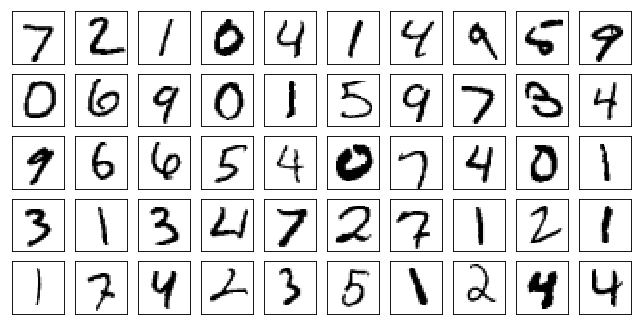

[tensor(7), tensor(2), tensor(1), tensor(0), tensor(4), tensor(1), tensor(4), tensor(9), tensor(5), tensor(9), tensor(0), tensor(6), tensor(9), tensor(0), tensor(1), tensor(5), tensor(9), tensor(7), tensor(3), tensor(4), tensor(9), tensor(6), tensor(6), tensor(5), tensor(4), tensor(0), tensor(7), tensor(4), tensor(0), tensor(1), tensor(3), tensor(1), tensor(3), tensor(4), tensor(7), tensor(2), tensor(7), tensor(1), tensor(2), tensor(1), tensor(1), tensor(7), tensor(4), tensor(2), tensor(3), tensor(5), tensor(1), tensor(2), tensor(4), tensor(4)]


In [19]:
data, _ = next(iter(test_loader))
output = model.forward(data)
predictions = [output[i].argmax() for i in range(50)]
plot_mnist(data.data.numpy(), (5, 10))

print (predictions)

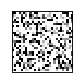

In [20]:
data, _ = next(iter(test_loader))
#img = data[2].view(-1, 1, 28, 28)
img = torch.randn((1, 784)).view(-1, 1, 28, 28)
to_plot = img.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
plot_mnist(to_plot, (1, 1))


In [23]:
from torch.autograd import Variable

def generate_image(img, cl):
    
    gen_img_par = Variable(img, requires_grad=True)    
    target = torch.ones((1), dtype=torch.long) * cl
    #target[cl] = 1
    #target = target.view(1, 10)
    
    loss_stats = []    
    lr = 5e-3
    
    for i in range(1, 10000001):  
             
        out = model.forward(gen_img_par)        
             
        gen_optim = optim.RMSprop([gen_img_par], lr=lr, weight_decay=0.)
        gen_optim.zero_grad()
        loss = F.cross_entropy(out, target)    
        loss.backward()          
        gen_optim.step()
        
        if i % 5000 == 0:    
            print ("Iteration {}: loss={} prediction={} lr={}".format(i,loss, out.argmax(), lr))
            ls = loss.detach().numpy()            
            loss_stats.append(ls)
            
            #1print("PRED=", out.argmax())
            #print("OUT=", out)
            #print("TR=", target)
                       
            if len(loss_stats) > 20:    
                down = False    
                for k in range(2, 11):    
                    if ls < loss_stats[-k]:
                        down = True
                        break
                # Loss is rising for 10 last epochs - decrease LR
                if not down:
                    lr = lr * 0.5
                    print ("Decreasing LR ..")

        if i % 100000 == 0:
            to_plot = gen_img_par.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
            plot_mnist(to_plot, (1, 1))
       
   
                        
    return gen_img_par, loss_stats    

Iteration 5000: loss=9.71240865510481e-11 prediction=4 lr=0.005
Iteration 10000: loss=6.66595667553338e-11 prediction=4 lr=0.005
Iteration 15000: loss=5.156408633411047e-11 prediction=4 lr=0.005
Iteration 20000: loss=4.2952308376698056e-11 prediction=4 lr=0.005
Iteration 25000: loss=3.6905589695379604e-11 prediction=4 lr=0.005
Iteration 30000: loss=3.241851231905457e-11 prediction=4 lr=0.005
Iteration 35000: loss=2.8880009494969272e-11 prediction=4 lr=0.005
Iteration 40000: loss=2.5988100560425664e-11 prediction=4 lr=0.005
Iteration 45000: loss=2.3707258378635743e-11 prediction=4 lr=0.005
Iteration 50000: loss=2.1866952693017083e-11 prediction=4 lr=0.005
Iteration 55000: loss=2.0300205960666062e-11 prediction=4 lr=0.005
Iteration 60000: loss=1.886490963443066e-11 prediction=4 lr=0.005
Iteration 65000: loss=1.759303813742008e-11 prediction=4 lr=0.005
Iteration 70000: loss=1.6481038755955524e-11 prediction=4 lr=0.005
Iteration 75000: loss=1.547206807117618e-11 prediction=4 lr=0.005
Itera

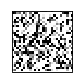

Iteration 105000: loss=1.1173284519827575e-11 prediction=4 lr=0.005
Iteration 110000: loss=1.0675904604795505e-11 prediction=4 lr=0.005
Iteration 115000: loss=1.0224709967587842e-11 prediction=4 lr=0.005
Iteration 120000: loss=9.812595180846984e-12 prediction=4 lr=0.005
Iteration 125000: loss=9.43245481721533e-12 prediction=4 lr=0.005
Iteration 130000: loss=9.08073616301408e-12 prediction=4 lr=0.005
Iteration 135000: loss=8.753886504564434e-12 prediction=4 lr=0.005
Iteration 140000: loss=8.448353128187591e-12 prediction=4 lr=0.005
Iteration 145000: loss=8.16058332020475e-12 prediction=4 lr=0.005
Iteration 150000: loss=7.894129794294713e-12 prediction=4 lr=0.005
Iteration 155000: loss=7.641887123099877e-12 prediction=4 lr=0.005
Iteration 160000: loss=7.407408020299044e-12 prediction=4 lr=0.005
Iteration 165000: loss=7.187139772213413e-12 prediction=4 lr=0.005
Iteration 170000: loss=6.981082378842984e-12 prediction=4 lr=0.005
Iteration 175000: loss=6.789235840187757e-12 prediction=4 lr=0

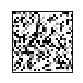

Iteration 205000: loss=5.81579229219642e-12 prediction=4 lr=0.005
Iteration 210000: loss=5.680789172402001e-12 prediction=4 lr=0.005
Iteration 215000: loss=5.552891479965183e-12 prediction=4 lr=0.005
Iteration 220000: loss=5.4285465012071654e-12 prediction=4 lr=0.005
Iteration 225000: loss=5.311306949806749e-12 prediction=4 lr=0.005
Iteration 230000: loss=5.197620112085133e-12 prediction=4 lr=0.005
Iteration 235000: loss=5.091038701721118e-12 prediction=4 lr=0.005
Iteration 240000: loss=4.984457291357103e-12 prediction=4 lr=0.005
Iteration 245000: loss=4.884981308350689e-12 prediction=4 lr=0.005
Iteration 250000: loss=4.792610752701876e-12 prediction=4 lr=0.005
Iteration 255000: loss=4.700240197053063e-12 prediction=4 lr=0.005
Iteration 260000: loss=4.61142235508305e-12 prediction=4 lr=0.005
Iteration 265000: loss=4.526157226791838e-12 prediction=4 lr=0.005
Iteration 270000: loss=4.444444812179427e-12 prediction=4 lr=0.005
Iteration 275000: loss=4.366285111245816e-12 prediction=4 lr=0.

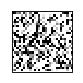

Iteration 305000: loss=3.964828465541359e-12 prediction=4 lr=0.005
Iteration 310000: loss=3.9044323330017505e-12 prediction=4 lr=0.005
Iteration 315000: loss=3.844036200462142e-12 prediction=4 lr=0.005
Iteration 320000: loss=3.787192781601334e-12 prediction=4 lr=0.005
Iteration 325000: loss=3.730349362740526e-12 prediction=4 lr=0.005
Iteration 330000: loss=3.6770586575585185e-12 prediction=4 lr=0.005
Iteration 335000: loss=3.623767952376511e-12 prediction=4 lr=0.005
Iteration 340000: loss=3.5704772471945034e-12 prediction=4 lr=0.005
Iteration 345000: loss=3.5207392556912964e-12 prediction=4 lr=0.005
Iteration 350000: loss=3.47455397786689e-12 prediction=4 lr=0.005
Iteration 355000: loss=3.4283687000424834e-12 prediction=4 lr=0.005
Iteration 360000: loss=3.382183422218077e-12 prediction=4 lr=0.005
Iteration 365000: loss=3.3359981443936704e-12 prediction=4 lr=0.005
Iteration 370000: loss=3.2933655802480644e-12 prediction=4 lr=0.005
Iteration 375000: loss=3.2507330161024584e-12 prediction

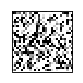

Iteration 405000: loss=3.0198066269804258e-12 prediction=4 lr=0.005
Iteration 410000: loss=2.9842794901924208e-12 prediction=4 lr=0.005
Iteration 415000: loss=2.9487523534044158e-12 prediction=4 lr=0.005
Iteration 420000: loss=2.9167779302952113e-12 prediction=4 lr=0.005
Iteration 425000: loss=2.8812507935072063e-12 prediction=4 lr=0.005
Iteration 430000: loss=2.8492763703980017e-12 prediction=4 lr=0.005
Iteration 435000: loss=2.8173019472887972e-12 prediction=4 lr=0.005
Iteration 440000: loss=2.7888802378583932e-12 prediction=4 lr=0.005
Iteration 445000: loss=2.7569058147491887e-12 prediction=4 lr=0.005
Iteration 450000: loss=2.7249313916399842e-12 prediction=4 lr=0.005
Iteration 455000: loss=2.6965096822095802e-12 prediction=4 lr=0.005
Iteration 460000: loss=2.668087972779176e-12 prediction=4 lr=0.005
Iteration 465000: loss=2.639666263348772e-12 prediction=4 lr=0.005
Iteration 470000: loss=2.611244553918368e-12 prediction=4 lr=0.005
Iteration 475000: loss=2.582822844487964e-12 predic

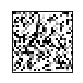

Iteration 505000: loss=2.4300561562995426e-12 prediction=4 lr=0.005
Iteration 510000: loss=2.405187160547939e-12 prediction=4 lr=0.005
Iteration 515000: loss=2.3803181647963356e-12 prediction=4 lr=0.005
Iteration 520000: loss=2.3590018827235326e-12 prediction=4 lr=0.005
Iteration 525000: loss=2.3376856006507296e-12 prediction=4 lr=0.005
Iteration 530000: loss=2.3163693185779266e-12 prediction=4 lr=0.005
Iteration 535000: loss=2.2950530365051236e-12 prediction=4 lr=0.005
Iteration 540000: loss=2.2737367544323206e-12 prediction=4 lr=0.005
Iteration 545000: loss=2.2524204723595176e-12 prediction=4 lr=0.005
Iteration 550000: loss=2.2311041902867146e-12 prediction=4 lr=0.005
Iteration 555000: loss=2.213340621892712e-12 prediction=4 lr=0.005
Iteration 560000: loss=2.192024339819909e-12 prediction=4 lr=0.005
Iteration 565000: loss=2.1742607714259066e-12 prediction=4 lr=0.005
Iteration 570000: loss=2.156497203031904e-12 prediction=4 lr=0.005
Iteration 575000: loss=2.135180920959101e-12 predict

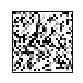

Iteration 605000: loss=2.0321522242738865e-12 prediction=4 lr=0.005
Iteration 610000: loss=2.0179413695586845e-12 prediction=4 lr=0.005
Iteration 615000: loss=2.000177801164682e-12 prediction=4 lr=0.005
Iteration 620000: loss=1.98596694644948e-12 prediction=4 lr=0.005
Iteration 625000: loss=1.971756091734278e-12 prediction=4 lr=0.005
Iteration 630000: loss=1.9539925233402755e-12 prediction=4 lr=0.005
Iteration 635000: loss=1.9397816686250735e-12 prediction=4 lr=0.005
Iteration 640000: loss=1.9255708139098715e-12 prediction=4 lr=0.005
Iteration 645000: loss=1.9113599591946695e-12 prediction=4 lr=0.005
Iteration 650000: loss=1.8971491044794675e-12 prediction=4 lr=0.005
Iteration 655000: loss=1.8829382497642655e-12 prediction=4 lr=0.005
Iteration 660000: loss=1.8687273950490635e-12 prediction=4 lr=0.005
Iteration 665000: loss=1.858069254012662e-12 prediction=4 lr=0.005
Iteration 670000: loss=1.84385839929746e-12 prediction=4 lr=0.005
Iteration 675000: loss=1.8332002582610585e-12 predictio

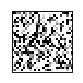

Iteration 705000: loss=1.758593271006248e-12 prediction=4 lr=0.005
Iteration 710000: loss=1.7479351299698465e-12 prediction=4 lr=0.005
Iteration 715000: loss=1.737276988933445e-12 prediction=4 lr=0.005
Iteration 720000: loss=1.7266188478970435e-12 prediction=4 lr=0.005
Iteration 725000: loss=1.715960706860642e-12 prediction=4 lr=0.005
Iteration 730000: loss=1.7053025658242404e-12 prediction=4 lr=0.005
Iteration 735000: loss=1.694644424787839e-12 prediction=4 lr=0.005
Iteration 740000: loss=1.6839862837514374e-12 prediction=4 lr=0.005
Iteration 745000: loss=1.673328142715036e-12 prediction=4 lr=0.005
Iteration 750000: loss=1.6626700016786344e-12 prediction=4 lr=0.005
Iteration 755000: loss=1.6555645743210334e-12 prediction=4 lr=0.005
Iteration 760000: loss=1.644906433284632e-12 prediction=4 lr=0.005
Iteration 765000: loss=1.6342482922482304e-12 prediction=4 lr=0.005
Iteration 770000: loss=1.6271428648906294e-12 prediction=4 lr=0.005
Iteration 775000: loss=1.616484723854228e-12 predictio

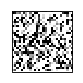

Iteration 805000: loss=1.5631940186722204e-12 prediction=4 lr=0.005
Iteration 810000: loss=1.5560885913146194e-12 prediction=4 lr=0.005
Iteration 815000: loss=1.545430450278218e-12 prediction=4 lr=0.005
Iteration 820000: loss=1.538325022920617e-12 prediction=4 lr=0.005
Iteration 825000: loss=1.531219595563016e-12 prediction=4 lr=0.005
Iteration 830000: loss=1.5205614545266144e-12 prediction=4 lr=0.005
Iteration 835000: loss=1.5134560271690134e-12 prediction=4 lr=0.005
Iteration 840000: loss=1.5063505998114124e-12 prediction=4 lr=0.005
Iteration 845000: loss=1.4992451724538114e-12 prediction=4 lr=0.005
Iteration 850000: loss=1.4921397450962104e-12 prediction=4 lr=0.005
Iteration 855000: loss=1.4850343177386094e-12 prediction=4 lr=0.005
Iteration 860000: loss=1.4743761767022079e-12 prediction=4 lr=0.005
Iteration 865000: loss=1.4672707493446069e-12 prediction=4 lr=0.005
Iteration 870000: loss=1.4601653219870059e-12 prediction=4 lr=0.005
Iteration 875000: loss=1.4530598946294049e-12 predi

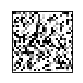

Iteration 905000: loss=1.4139800441625994e-12 prediction=4 lr=0.005
Iteration 910000: loss=1.4068746168049984e-12 prediction=4 lr=0.005
Iteration 915000: loss=1.3997691894473974e-12 prediction=4 lr=0.005
Iteration 920000: loss=1.3926637620897964e-12 prediction=4 lr=0.005
Iteration 925000: loss=1.3855583347321954e-12 prediction=4 lr=0.005
Iteration 930000: loss=1.3820056210533949e-12 prediction=4 lr=0.005
Iteration 935000: loss=1.3749001936957939e-12 prediction=4 lr=0.005
Iteration 940000: loss=1.3677947663381929e-12 prediction=4 lr=0.005
Iteration 945000: loss=1.3642420526593924e-12 prediction=4 lr=0.005
Iteration 950000: loss=1.3571366253017914e-12 prediction=4 lr=0.005
Iteration 955000: loss=1.3500311979441904e-12 prediction=4 lr=0.005
Iteration 960000: loss=1.3464784842653899e-12 prediction=4 lr=0.005
Iteration 965000: loss=1.3393730569077889e-12 prediction=4 lr=0.005
Iteration 970000: loss=1.3322676295501878e-12 prediction=4 lr=0.005


KeyboardInterrupt: 

In [24]:
new_image_randn, loss_stats = generate_image(img, 4)

In [ ]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.set_title("Loss")
plt.plot(loss_stats[50:], color='green', label='Train loss')

ax.set_ylabel("Loss")
ax.set_xlabel("Iterations")
ax.legend()
